In [108]:
import scipy.io as scio
import numpy as np    
import matplotlib.pyplot as plt
import sys
import os
import math
import pprint
import cv2
from scipy.misc import imsave
from helper import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [121]:
# Setting the directories
import os
cwd = os.getcwd()
main_direct = '/datasets/OCTData/'
directory = cwd + main_direct # main directory
# Extensions
raw_ext = '.tif'
label_ext = '.JPG'

files = {}
for number, filename in enumerate(sorted(os.listdir(directory)), start=1):
    files[number] = filename

sub_directory = directory+files[2]+'/'
print(sub_directory)

image = plt.imread(sub_directory+'con_'+files[2]+raw_ext)
# show_main_image(image)
label_image = plt.imread(sub_directory+'label_'+files[2]+label_ext)
# show_main_image(label_image)


# Testing images saved correctly
# test_dir1 = "/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/H1_N01848_LA_1_272/Resized_train/con_H1_N01848_LA_1_272_1.tif"
# test_dir2 = "/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/H1_N01848_LA_1_272/Resized_train/label_H1_N01848_LA_1_272_1.JPG"
# test_dir3 = "/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/H1_N01848_LA_1_272/Resized_train/label_H1_N01848_LA_1_272_colour_1.JPG"
# image1 = plt.imread(test_dir1)
# image2 = plt.imread(test_dir2)
# image3 = plt.imread(test_dir3)
# print(image1.shape)
# print(image2.shape)
# print(image3.shape)

# show_main_image(image1)
# show_main_image(image2)
# show_main_image(image3)

/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/H1_N01848_LA_1_388/


#### Rename Labelled Images

In [122]:
# Rename files in folder
rename = False

if rename:
    for number, filename in sorted(files.items()):
        sub_directory = directory+files[number]+'/'
        for f in os.listdir(sub_directory):
            ext = f[-4:]
            if ext == label_ext:
                print(sub_directory)
                old_filename = sub_directory+f
                new_filename = sub_directory+'label_'+filename+label_ext
                print("Old Filename: {}, New Filename: {}".format(old_filename, new_filename))
                os.rename(old_filename, new_filename)

#### Create New Directory

Only have 19 atriums - need to create more segments of data

In [4]:
make_new_directory = False
if make_new_directory:
    for number, filename in sorted(files.items()):
        sub_directory = directory+files[number]+'/'
        for f in os.listdir(sub_directory):
            ext = f[-4:]
            # If the file isn't an ipynb notebook file and it's the .tif file
            if ext == raw_ext:
                path = sub_directory+'Resized_train'
                os.mkdir(path)

#### Make Segments

In [5]:
make_segments = False
if make_segments:
    for number, filename in sorted(files.items()):
        sub_directory = directory+files[number]+'/'
        for f in os.listdir(sub_directory):
            ext = f[-4:]
            shape = 2
            if ext == raw_ext or ext == label_ext:
                image_file = sub_directory+f
                image = plt.imread(image_file)
                
                # Crop all images
                if len(image.shape) == 2:
                    height, width = image.shape
                    if width > 600:
                        image = crop_image(image, 0, 600) # Crop all images at 512,600
                elif len(image.shape) == 3:
                    height, width, colour = image.shape
                    if width > 600:
                        image = crop_image(image, 0, 600, colour) # Crop all images at 512,600
                
                # Segment all iamges
                segmented_images = segment_image(image, 0, 600, 64)
                for i in range(len(segmented_images)):
                    if len(image.shape) == 2:
                        save_image(segmented_images[i], sub_directory, f, ext, i, False)
                    elif len(image.shape) == 3:
                         # Pixel loop
        #                 for pix in range(512):
        #                     for p in range(64):
        #                         print(segmented_images[i][pix][p])

        #                 NOTE: WHEN SAVING IMAGES, HAVE TO HAVE CODE FOR COLOUR OF IMAGES TOO! 
        #                 segmented_images[i] = np.transpose(segmented_images[i], (2, 0, 1))
        #                 segmented_images[i].shape = (1,1,512,64)
        #                 show_main_image(image)
                        save_image(segmented_images[i], sub_directory, f, ext, i, True)
                        segmented_images[i] = rgb_to_grey(segmented_images[i]) # convert to greyscale
                        save_image(segmented_images[i], sub_directory, f, ext, i, False)

####  Helper functions to find colours in image

In [6]:
def to_rgb(color):
    r,g,b = color
    return (int(r),int(g),int(b))

# Source: https://stackoverflow.com/questions/9694165/convert-rgb-color-to-english-color-name-like-green-with-python
def closest_colour(requested_colour):
    min_colours = {}
    for key, name in wb.css3_hex_to_names.items():
        r_c, g_c, b_c = wb.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]

def get_colour_name(requested_colour):
    try:
        closest_name = actual_name = wb.rgb_to_name(requested_colour)
    except ValueError:
        closest_name = closest_colour(requested_colour)
        actual_name = None
    return actual_name, closest_name

# Source Source: https://stackoverflow.com/questions/45043617/count-the-number-of-objects-of-different-colors-in-an-image-in-python
def find_colors(file_name):
    from skimage import io, morphology, measure
    from sklearn.cluster import KMeans

    img = io.imread(file_name)

    rows, cols, bands = img.shape
    X = img.reshape(rows*cols, bands)


    kmeans = KMeans(n_clusters=6, random_state=0).fit(X)
    labels = kmeans.labels_.reshape(rows, cols)

    for i in np.unique(labels):
        blobs = np.int_(morphology.binary_opening(labels == i))
        color = np.around(kmeans.cluster_centers_[i])
        actual_name, closest_name = get_colour_name(to_rgb(color))
        count = len(np.unique(measure.label(blobs))) - 1
        
        print('Color: {}, RGB: {}  >>  Objects: {}'.format(closest_name,color, count))
        
def pixel_colors(file_name):
    from skimage import io
    if type(file_name) == str:
        img = io.imread(file_name)
    else:
        img = file_name
    
    new_img = np.copy(img)
    rows, cols, bands = new_img.shape
    
    dict_of_colours = {}
    for row in range(150,350):
        if row % 25 == 0:
            print(row)
        for col in range(0,50):
            pixel_color = new_img[row][col]
            actual, close = get_colour_name(pixel_color)
            if actual != None:
                if actual in dict_of_colours:
                    dict_of_colours[actual] += 1
                else:
                    dict_of_colours[actual] = 1
                list_of_colors.add(actual)
            else:
                if close in dict_of_colours:
                    dict_of_colours[close] += 1
                else:
                    dict_of_colours[close] = 1

    return dict_of_colours

#### Finding Colours/id of a class
https://www.w3schools.com/colors/colors_picker.asp

In [56]:
import webcolors as wb
import numpy as np
from skimage import io
from skimage.color import rgb2lab, deltaE_cie76
from PIL import Image

# Source: https://stackoverflow.com/questions/44428315/similar-color-detection-in-python

# Blurring image 
def blur_image(img, b):
    if b == "average":
        kernel = np.ones((3,6),np.float32)/25
        blurred = cv2.filter2D(img,-1,kernel)
    elif b == "gaussian":
    # Gaussian Blur
        blur=cv2.GaussianBlur(img,(13,13),0)
        blurred=cv2.cvtColor(blur,cv2.COLOR_BGR2HSV)
    elif b == "bilateral":
    # Bilaterial Filter
        blur=cv2.bilateralFilter(img,4,25,25)
        blurred=cv2.cvtColor(blur,cv2.COLOR_BGR2HSV)
    return blurred

def turn_array(rgb):
    '''
    turn rgb into np.array
    '''
    return np.uint8(np.asarray([[rgb]]))

def turn_rgb_2_lab(color, lab):
    '''
    Convert RGB to CIE 1976 L*a*b*
    '''
    return deltaE_cie76(rgb2lab(color),lab)

def rgb_to_id(rgb, threshold, color, ids, lab):
    '''
    Convert rgb to id
    '''
#     print(get_colour_name(color), color, ids)
    color_3d = turn_array(color)
    dE_color = turn_rgb_2_lab(color_3d, lab)
    rgb[dE_color < threshold] = ids

    return rgb

def ref_colour(rgb):
    '''
    Finding colours within a range of the colour input
    input = pixel
    '''
#     rgb = io.imread('https://i.stack.imgur.com/npnrv.png') # to show where the images overlap
    new_rgb = np.copy(rgb)
    
    lab = rgb2lab(new_rgb)
    
    threshold = 15  
    
    # Lime and limegreen is same as Green 
    green = [0,128,0]
    lime = [0,255,0]
    limegreen = [50, 205, 50]
    
    rgb_to_id(new_rgb, threshold, green, 0, lab)
    rgb_to_id(new_rgb, threshold, lime, 0, lab)
    rgb_to_id(new_rgb, threshold, limegreen, 0, lab)
    
    # Orange is same as dark orange
    orange = [255, 165, 0]
    darkorange = [255, 140, 0]
    chocolate = [180,101,24]
    
    rgb_to_id(new_rgb, threshold, orange, 1, lab)
    rgb_to_id(new_rgb, threshold, darkorange, 1, lab)
    rgb_to_id(new_rgb, threshold, chocolate, 1, lab)
    
    # Dark Violet = Purple = Medium Purple = Darkorchid
    purple = [128,0,128]
    darkviolet = [177,10,255]
    mediumpurple = [147, 112, 219]
    darkorchid = [153, 50, 204]
    
    rgb_to_id(new_rgb, threshold, purple, 2, lab)
    rgb_to_id(new_rgb, threshold, darkviolet, 2, lab)
    rgb_to_id(new_rgb, threshold, mediumpurple, 2, lab)
    rgb_to_id(new_rgb, threshold, darkorchid, 2, lab)
    
    # Magenta/Fuschia
    magenta = [255,0,255]
    darkmagenta = [139, 0, 139]
    
    magenta_threshold = 20
    
    rgb_to_id(new_rgb, magenta_threshold, magenta, 3, lab)
    rgb_to_id(new_rgb, magenta_threshold, darkmagenta, 3, lab)
    
    # Blue
    blue = [0, 0, 255]
    darkslateblue = [72, 61, 139]
    midnightblue = [25, 25, 112]
    mediumblue = [0, 0, 205]
    
    rgb_to_id(new_rgb, threshold, blue, 4, lab)
    rgb_to_id(new_rgb, threshold, darkslateblue, 4, lab)
    rgb_to_id(new_rgb, threshold, midnightblue, 4, lab)
    rgb_to_id(new_rgb, threshold, mediumblue, 4, lab)
    
    # Yellow = Gold
    yellow = [255,255,0]
    gold = [255, 215, 0]
    goldenrod = [218, 165, 32]
    goldenrod2 = [183,178,36]
    darkgoldenrod = [184, 134, 11]
    
    rgb_to_id(new_rgb, threshold, yellow, 5, lab)
    rgb_to_id(new_rgb, threshold, gold, 5, lab)
    rgb_to_id(new_rgb, threshold, goldenrod, 5, lab)
    rgb_to_id(new_rgb, threshold, goldenrod2, 5, lab)
    rgb_to_id(new_rgb, threshold, darkgoldenrod, 5, lab)
    
    # Red = OrangeRed
    red = [255,0,0]
    orangered = [255, 69, 0]
    firebrick = [181,17,17]
    
    rgb_to_id(new_rgb, threshold, red, 6, lab)
    rgb_to_id(new_rgb, threshold, orangered, 6, lab)
    rgb_to_id(new_rgb, threshold, firebrick, 6, lab)
    
    # Black = Grey 
    black = [0, 0, 0]
    dimgrey = [105, 105, 105]
    darkslategrey = [47, 79, 79]
    lightgrey = [211, 211, 211]
    gainsboro = [220, 220, 220]
    grey = [128, 128, 128]
    lightslategrey = [119, 136, 153]
    darkgrey = [169, 169, 169]
    
    rgb_to_id(new_rgb, threshold, black, -1, lab)
    rgb_to_id(new_rgb, threshold, dimgrey, -1, lab)
    rgb_to_id(new_rgb, threshold, darkslategrey, -1, lab)
    rgb_to_id(new_rgb, threshold, lightgrey, -1, lab)
    rgb_to_id(new_rgb, threshold, gainsboro, -1, lab)
    rgb_to_id(new_rgb, threshold, grey, -1, lab)
    rgb_to_id(new_rgb, threshold, lightslategrey, -1, lab)
    rgb_to_id(new_rgb, threshold, darkgrey, -1, lab)


    new_grey = cv2.cvtColor( new_rgb, cv2.COLOR_RGB2GRAY ) # convert image to grayscale
    
    return new_grey

def convert_to_id_image(image):
    '''
    convert rgb images to id
    '''
    returned_grey_image = ref_colour(image)
    rows, cols = returned_grey_image.shape
    for x in range(0, rows):
        for j in range(0,cols):
            if returned_grey_image[x][j] > 7: # Setting values in the array to void if they're not in labels
                returned_grey_image[x][j] = -1

    return returned_grey_image

def convert_to_rgb_image(id_image):
    '''
    Convert id back to rgb 
    '''
    rows, cols = id_image.shape

    lime = [0,255,0] # id = 0
    darkorange = [255, 140, 0] # id = 1
    darkviolet = [177,10,255] # id = 2
    magenta = [255,0,255] # id = 3
    blue = [0, 0, 255] # id = 4
    yellow = [255, 255, 0] # id = 5
    red = [255,0,0] # id = 6
    black = [0, 0, 0]# id = -1
    
    colors = [ lime, darkorange, darkviolet, magenta, blue, yellow, red]
    new_image = np.zeros((rows,cols,3))
    for x in range(0, rows):
        for j in range(0,cols):
            pixel_value = int(id_image[x][j])
            if pixel_value > 6: # Setting values in the array to black if they're not in labels
                new_image[x][j] = black
            else:
                new_image[x][j] = colors[pixel_value] # setting id to colours - values between 0-6
    return new_image.astype(np.uint8)

Blurred images produce worse results as can be seen in the function below.

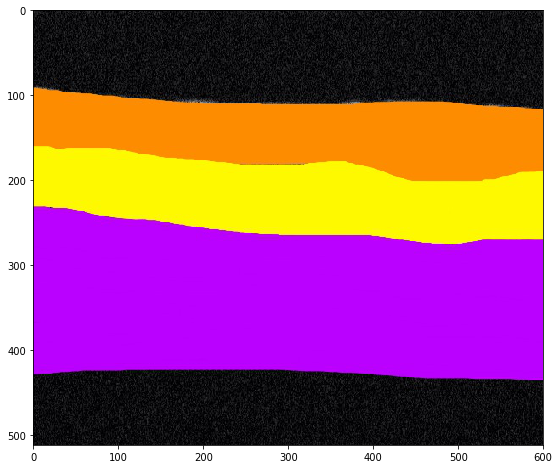

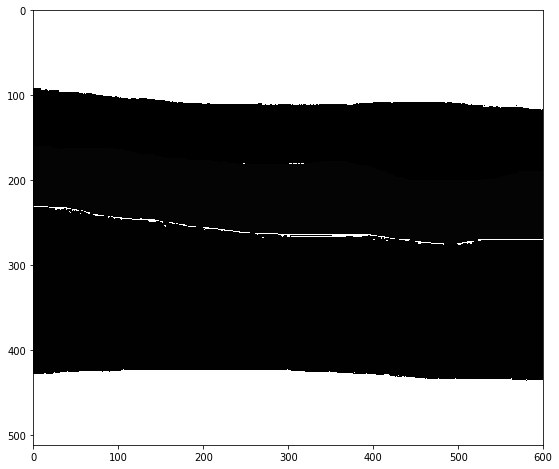

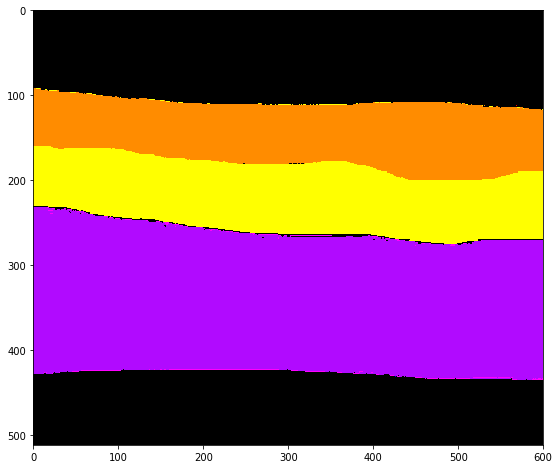

In [60]:
def produce_images(file_name,type_of_blur, blur=False):

    image = plt.imread(file_name)
    if blur == True:
        image = blur_image(image, type_of_blur)

    show_main_image(image)
    id_image = convert_to_id_image(image)
    show_main_image(id_image)
    rgb_image = convert_to_rgb_image(id_image)
    show_main_image(rgb_image)
    return id_image

# file_name = '/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/H1_N01848_LV_1_194/label_H1_N01848_LV_1_194.JPG'
# produce_images(file_name, blur=False)
file_name = '/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/H1_N01848_LA_1_272/label_H1_N01848_LA_1_272.JPG'
produce_images(file_name, "", blur=False)

# convert_to_id_image(label_image)
# convert_to_id_image(blurred_image) # blurred image setting orange colours etc to different colour.

In [102]:
# blurred_image = blur_image(label_image)
# pprint.pprint(pixel_colors(blurred_image))

In [32]:
main_direct = '/datasets/OCTData/'
directory = cwd + main_direct # main directory

# Extensions
raw_ext = '.tif'
label_ext = '.JPG'

files = {}
for number, filename in enumerate(sorted(os.listdir(directory)), start=1):
    files[number] = filename

for i in range(1,3):
    type_of_heart = files[i][10:]
    if type_of_heart[1:2] == 'A':
        sub_directory = directory+files[i]+'/'
        file_name = sub_directory+'label_'+files[i]+label_ext
    # elif type_of_heart[1:2] == 'V':
    show_main_image(label_image)

150
175
200
225
250
275
300
325
150
175
200
225
250
275
300
325


In [ ]:
# Applying Weighting algorithm to an image
# count = [0]*8
# weighted_images = []
# for i in range(110):
#     image = resized_labeledimages[i]
#     weighted_image = np.zeros((216,500))
#     for j in range(216):
#         for k in range(500):
#              if(image[j][k]==1):
#                 w2 = 11.459
#              elif(image[j][k] == 2):
#                 w2 = 5.63
#              elif(image[j][k]== 3):
#                 w2 = 11.007 
#              elif(image[j][k] == 4):
#                 w2 = 14.368 
#              elif(image[j][k]== 5):
#                 w2 = 3.336 
#              elif(image[j][k]== 6):
#                 w2 = 13.647 
#              elif(image[j][k]== 7):
#                 w2 = 16.978 
#              else:
#                 w2 = 0
#              if(j!=0 and j!=215):
#                 if(image[j+1][k]-image[j-1][k]>0 and w2<>0):
#                     w1 = 15 
#                    # count = count +1
#                     count[int(image[j-1][k])] = count[int(image[j-1][k])] + 1 
#                 else:
#                     w1 = 0
#              else:
#                 w1 = 0
#              w = 1 + w1 + w2
#              weighted_image[j][k] = w
#     weighted_images.append(weighted_image)

In [ ]:
# Saving Weight image
# for item in range(110):
#     imsave('Dataset/Weighted/weighted_'+str(item+1)+'.png',weighted_images[item])

In [ ]:
# Saving array of weighted_images
# np.save('weighted_images.npy',np.array(weighted_images))